# Multi-model mean - Seasonal maps

## Objective 

The objective of this notebook is to create multi-model averages of sea ice cover by incorporating each model's score using the selected Gaussian weighting method. This weighted average will then be used to generate sea ice cover maps according to different warming levels for each season.

In [1]:
from watermark import watermark
%load_ext watermark
print(watermark())

Last updated: 2025-07-29T13:31:52.211114+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-55-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
import sys
import os

# Absolute path to the folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# adding the path to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Projet root ajouté au path:", project_root)

Projet root ajouté au path: /home/jovyan/M2_SeaIce_project


In [3]:
from module import *

/srv/conda/envs/notebook/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [4]:
%watermark --iversions

skimage   : 0.25.0
watermark : 2.5.0
cartopy   : 0.24.0
matplotlib: 3.10.0
sys       : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
xarray    : 2025.1.1
seaborn   : 0.13.2
csv       : 1.0
pandas    : 2.2.3
cdo       : 1.6.1
netCDF4   : 1.7.2
xesmf     : 0.8.8
numpy     : 2.0.2



## List of files used

In [5]:
# Display files as a list
files = os.listdir("/home/jovyan/private-storage/output_data/interp_models_SIW_1995_2014/")

nc_files = [filename for filename in files if filename.endswith(".nc")]
nc_files

['BCC-CSM2-MR_SIW_reprojete.nc',
 'CAMS-CSM1-0_SIW_reprojete.nc',
 'CESM2_SIW_reprojete.nc',
 'CESM2-WACCM_SIW_reprojete.nc',
 'CNRM-CM6-1_SIW_reprojete.nc',
 'CNRM-CM6-1-HR_SIW_reprojete.nc',
 'CanESM5_SIW_reprojete.nc',
 'FGOALS-f3-L_SIW_reprojete.nc',
 'FIO-ESM-2-0_SIW_reprojete.nc',
 'GFDL-CM4_SIW_reprojete.nc',
 'GFDL-ESM4_SIW_reprojete.nc',
 'INM-CM4-8_SIW_reprojete.nc',
 'INM-CM5-0_SIW_reprojete.nc',
 'IPSL-CM6A-LR_SIW_reprojete.nc',
 'MIROC-ES2L_SIW_reprojete.nc',
 'MIROC6_SIW_reprojete.nc',
 'MPI-ESM1-2-HR_SIW_reprojete.nc',
 'MRI-ESM2-0_SIW_reprojete.nc',
 'NESM3_SIW_reprojete.nc']

## Sea ice reference

In [6]:
# path and file of the sea ice reference
path = "/home/jovyan/M2_SeaIce_project/Data/input_data/sea_ice_ref3.nc"
sea_ice_ref = xr.open_dataarray(path)
seaice_cover = sea_ice_ref

In [7]:
# path and file of the area
path = "/home/jovyan/M2_SeaIce_project/Data/input_data/areacella/gridarea_seaice_ref.nc"
area = xr.open_dataset(path)

In [8]:
# season definition
season_months = {
    "DJF": [12, 1, 2], #winter
    "MAM": [3, 4, 5], #spring
    "JJA": [6, 7, 8], #summer
    "SON": [9, 10, 11] #autumn
}

In [9]:
# Calculate Seasonal Average Sea Ice Cover from Reference Data
seasonal_seaice_reference = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = seaice_cover.sel(month=months_float)
    seasonal_seaice_reference[season] = da_sel.mean(dim="month", skipna=True)

In [10]:
# Extract Seasonal Sea Ice Cover Data for Each Season
djf_seaice_reference = seasonal_seaice_reference['DJF']
mam_seaice_reference = seasonal_seaice_reference['MAM']
jja_seaice_reference = seasonal_seaice_reference['JJA']
son_seaice_reference = seasonal_seaice_reference['SON']

In [11]:
# Convert seasonal seaice cover to binary (presence/absence) using a 0.15 threshold
djf_seaice_reference_binary = (djf_seaice_reference > 0.15).astype(int)
mam_seaice_reference_binary = (mam_seaice_reference > 0.15).astype(int)
jja_seaice_reference_binary = (jja_seaice_reference > 0.15).astype(int)
son_seaice_reference_binary = (son_seaice_reference > 0.15).astype(int)

In [12]:
djf_seaice_reference_binary

<xarray.DataArray (lat: 180, lon: 360)> Size: 518kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5

In [13]:
djf_seaice_reference_binary = djf_seaice_reference_binary.sel(lat=djf_seaice_reference_binary.lat >= 20)
mam_seaice_reference_binary = mam_seaice_reference_binary.sel(lat=mam_seaice_reference_binary.lat >= 20)
jja_seaice_reference_binary = jja_seaice_reference_binary.sel(lat=jja_seaice_reference_binary.lat >= 20)
son_seaice_reference_binary = son_seaice_reference_binary.sel(lat=son_seaice_reference_binary.lat >= 20)

In [14]:
# variable selection
area = area["cell_area"]

# Convert area in km2
area_km2 = area * 1e-6

#Calculate winter seaice-covered area (km²)
seaice_cover_km2_winter = (djf_seaice_reference_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)

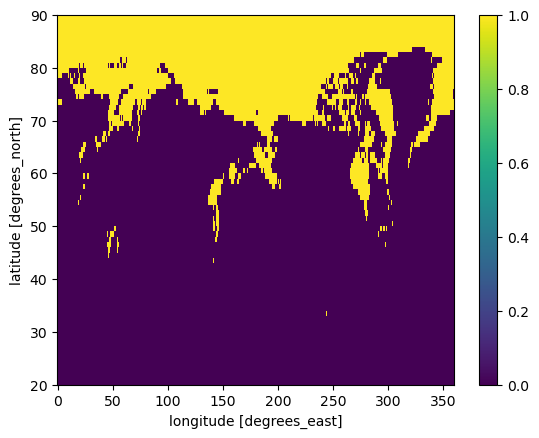

In [15]:
son_seaice_reference_binary.plot()

## Multi-Model Average with Score Weighting – Gaussian Function

In [16]:
# Load model scores from CSV file
scores_modeles = pd.read_csv("/home/jovyan/private-storage/output_data/scores_modeles_seaice_50%_nh.csv", index_col=0)
scores_modeles

,Erreur_moyenne,Scores_exp,Scores_gauss
modèle_x,,,
GFDL-CM4,2.659189e+05,1.000000,1.000000
INM-CM5-0,4.146250e+05,0.945850,0.975510
CNRM-CM6-1-HR,4.330387e+05,0.939352,0.969170
CanESM5,4.614571e+05,0.929411,0.958035
FGOALS-f3-L,5.357366e+05,0.903922,0.921615
INM-CM4-8,5.910951e+05,0.885381,0.888199
MRI-ESM2-0,6.968406e+05,0.851015,0.812039
BCC-CSM2-MR,7.221793e+05,0.842980,0.791827
CNRM-CM6-1,7.704066e+05,0.827897,0.751740


In [17]:
# Create a dictionary of seaice cover data for each model by loading and processing relevant files
seaice_cover_dict = {}

for i, files in enumerate(nc_files):
    model_name = files.split("_")[0]
    
    path_siconc = os.path.join("/home/jovyan/private-storage/output_data/interp_models_SIW_1995_2014/", files)
    path_areacella = os.path.join("/home/jovyan/private-storage/output_data/areacella_recalcule/", files.replace("SIW_reprojete", "gridarea_hist_recalcule"))
    path_sftlf = os.path.join("/home/jovyan/private-storage/output_data/interp_sftlf/", files.replace("SIW", "sftlf"))
                                 
    ds_siconc, ds_area, ds_sftlf = get_data(path_siconc, path_areacella, path_sftlf)
    siconc = extraction_variable(ds_siconc, sftlf=ds_sftlf["sftlf"])
    sftlf = ds_sftlf["sftlf"]

    seaice_cover_dict[model_name] = siconc

La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 'siconcbin' est en %. Conversion en fraction.
La variable 's

In [18]:
# Print the 'type' coordinate values for each model's data array, if present
for model, da in seaice_cover_dict.items():
    if 'type' in da.coords:
        print(f"{model}: {da['type'].values}")

BCC-CSM2-MR: b'sea_ice'
CAMS-CSM1-0: b'sea_ice'
FGOALS-f3-L: b'sea_ice'
FIO-ESM-2-0: b'sea_ice'
MPI-ESM1-2-HR: b'sea_ice'
NESM3: b'sea_ice'


In [19]:
# Remove 'type' coordinate from data arrays if it exists, then store cleaned arrays and model names
cleaned_siconc = []
model_names = []

for model, da in seaice_cover_dict.items():
    if 'type' in da.coords:
        da = da.drop_vars('type')

    cleaned_siconc.append(da)
    model_names.append(model)

In [20]:
# Concatenate cleaned snow cover data arrays along a new 'model' dimension
all_siconc = xr.concat(cleaned_siconc, dim=xr.DataArray(model_names, dims="model"))

In [21]:
# Create the weight vector for each model based on its obtained score
weights = xr.DataArray(
    scores_modeles["Scores_gauss"],
    coords = {"modèle_x": scores_modeles.index},
    dims="modèle_x"
)

In [22]:
# Rename coordinate from 'modele_x' to 'model' and replace underscores with hyphens in model names
weights = weights.rename({"modèle_x": "model"})
weights = weights.assign_coords(
    model=[m.replace("_", "-") for m in weights.model.values]
)

In [23]:
#Apply weights to each model’s snow cover data
weighted = all_siconc * weights
weighted

<xarray.DataArray (model: 19, GSAT: 23, month: 12, lat: 70, lon: 360)> Size: 1GB
array([[[[[           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          ...,
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan]],

         [[           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
...
          [2.50986944e-07, 2.38262182e-07, 2.38262182e-07, ...,
           2.14475257e-07, 2.14475257e-07, 2.14475257e-07],
          [3.52417671e-07, 3.52417671e-07, 3.52417671e-07, ...,
           3.35360430e-07, 3.35360430e-07, 3.52417671e-07],
          [5.72394584e-07, 5.72394584e-07, 5.72394584e-07, ...,
           5.72394584e-07, 5.72394584e-07, 5.72394584e-07]],

         [[           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          ...,
          [1.97234360e-07, 1.82561157e-07, 1.82561157e-07, ...,
           1.61154112e-07, 1.61154112e-07, 1.61154112e-07],
          [1.62076754e-06, 1.62076754e-06, 1.62076754e-06, ...,
           3.39852332e-05, 3.39852332e-05, 1.62076754e-06],
          [3.29440636e-04, 3.29440636e-04, 3.29440636e-04, ...,
           3.29440636e-04, 3.29440636e-04, 3.29440636e-04]]]]])
Coordinates:
  * month    (month) float64 96B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * GSAT     (GSAT) float64 184B -0.5 -0.25 0.0 0.25 0.5 ... 4.25 4.5 4.75 5.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5
  * model    (model) <U13 988B 'BCC-CSM2-MR' 'CAMS-CSM1-0' ... 'NESM3'

In [24]:
# Align sea ice cover data and weights along common models to ensure matching dimensions
all_siconc, weights = xr.align(all_siconc, weights, join="inner")

In [25]:
# Calculate weighted average sea ice cover across models using their respective weights
mean_siconc_pondere = (all_siconc * weights).sum(dim="model") / weights.sum(dim="model")

In [26]:
# Select weighted sea ice cover data for specific GSAT warming levels
siconc_gsat_05_pondere = mean_siconc_pondere.sel(GSAT=-0.5)
siconc_gsat0_pondere = mean_siconc_pondere.sel(GSAT=0.0)
siconc_gsat1_pondere = mean_siconc_pondere.sel(GSAT=1.0)
siconc_gsat2_pondere = mean_siconc_pondere.sel(GSAT=2.0)
siconc_gsat3_pondere = mean_siconc_pondere.sel(GSAT=3.0)
siconc_gsat4_pondere = mean_siconc_pondere.sel(GSAT=4.0)

## Definition of seasons

In [27]:
# Definition of seasons
season_months = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11]
}

In [28]:
#Calculate seasonal averages of weighted sea ice cover for different GSAT warming levels
seasonal_siconc_gsat_05_pondere = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = siconc_gsat_05_pondere.sel(month=months_float)
    seasonal_siconc_gsat_05_pondere[season] = da_sel.mean(dim="month", skipna=True)
    
seasonal_siconc_gsat0_pondere = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = siconc_gsat0_pondere.sel(month=months_float)
    seasonal_siconc_gsat0_pondere[season] = da_sel.mean(dim="month", skipna=True)
    
seasonal_siconc_gsat1_pondere = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = siconc_gsat1_pondere.sel(month=months_float)
    seasonal_siconc_gsat1_pondere[season] = da_sel.mean(dim="month", skipna=True)

seasonal_siconc_gsat2_pondere = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = siconc_gsat2_pondere.sel(month=months_float)
    seasonal_siconc_gsat2_pondere[season] = da_sel.mean(dim="month", skipna=True)

seasonal_siconc_gsat3_pondere = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = siconc_gsat3_pondere.sel(month=months_float)
    seasonal_siconc_gsat3_pondere[season] = da_sel.mean(dim="month", skipna=True)

seasonal_siconc_gsat4_pondere = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = siconc_gsat4_pondere.sel(month=months_float)
    seasonal_siconc_gsat4_pondere[season] = da_sel.mean(dim="month", skipna=True)

seasonal_mean_siconc_pondere = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = mean_siconc_pondere.sel(month=months_float)
    seasonal_mean_siconc_pondere[season] = da_sel.mean(dim="month", skipna=True)

In [29]:
# Convert weighted seasonal sea ice cover to binary presence/absence using a 0.15 threshold
seasonal_siconc_binary_50_pondere = {
    season: xr.where(da > 0.15, 1, 0).where(~da.isnull())
    for season, da in seasonal_mean_siconc_pondere.items()
}

In [30]:
# Select binary DJF sea ice cover data for specific GSAT warming levels
djf_siconc_gsat05 = seasonal_siconc_binary_50_pondere['DJF'].sel(GSAT=-0.5)
djf_siconc_gsat0 = seasonal_siconc_binary_50_pondere['DJF'].sel(GSAT=0)
djf_siconc_gsat1 = seasonal_siconc_binary_50_pondere['DJF'].sel(GSAT=1)
djf_siconc_gsat2 = seasonal_siconc_binary_50_pondere['DJF'].sel(GSAT=2)
djf_siconc_gsat3 = seasonal_siconc_binary_50_pondere['DJF'].sel(GSAT=3)
djf_siconc_gsat4 = seasonal_siconc_binary_50_pondere['DJF'].sel(GSAT=4)

In [31]:
# Select binary MAM sea ice cover data for specific GSAT warming levels
mam_siconc_gsat05 = seasonal_siconc_binary_50_pondere['MAM'].sel(GSAT=-0.5)
mam_siconc_gsat0 = seasonal_siconc_binary_50_pondere['MAM'].sel(GSAT=0)
mam_siconc_gsat1 = seasonal_siconc_binary_50_pondere['MAM'].sel(GSAT=1)
mam_siconc_gsat2 = seasonal_siconc_binary_50_pondere['MAM'].sel(GSAT=2)
mam_siconc_gsat3 = seasonal_siconc_binary_50_pondere['MAM'].sel(GSAT=3)
mam_siconc_gsat4 = seasonal_siconc_binary_50_pondere['MAM'].sel(GSAT=4)

In [32]:
# Select binary JJA sea ice cover data for specific GSAT warming levels
jja_siconc_gsat05 = seasonal_siconc_binary_50_pondere['JJA'].sel(GSAT=-0.5)
jja_siconc_gsat0 = seasonal_siconc_binary_50_pondere['JJA'].sel(GSAT=0)
jja_siconc_gsat1 = seasonal_siconc_binary_50_pondere['JJA'].sel(GSAT=1)
jja_siconc_gsat2 = seasonal_siconc_binary_50_pondere['JJA'].sel(GSAT=2)
jja_siconc_gsat3 = seasonal_siconc_binary_50_pondere['JJA'].sel(GSAT=3)
jja_siconc_gsat4 = seasonal_siconc_binary_50_pondere['JJA'].sel(GSAT=4)

In [33]:
# Select binary SON sea ice cover data for specific GSAT warming levels
son_siconc_gsat05 = seasonal_siconc_binary_50_pondere['SON'].sel(GSAT=-0.5)
son_siconc_gsat0 = seasonal_siconc_binary_50_pondere['SON'].sel(GSAT=0)
son_siconc_gsat1 = seasonal_siconc_binary_50_pondere['SON'].sel(GSAT=1)
son_siconc_gsat2 = seasonal_siconc_binary_50_pondere['SON'].sel(GSAT=2)
son_siconc_gsat3 = seasonal_siconc_binary_50_pondere['SON'].sel(GSAT=3)
son_siconc_gsat4 = seasonal_siconc_binary_50_pondere['SON'].sel(GSAT=4)

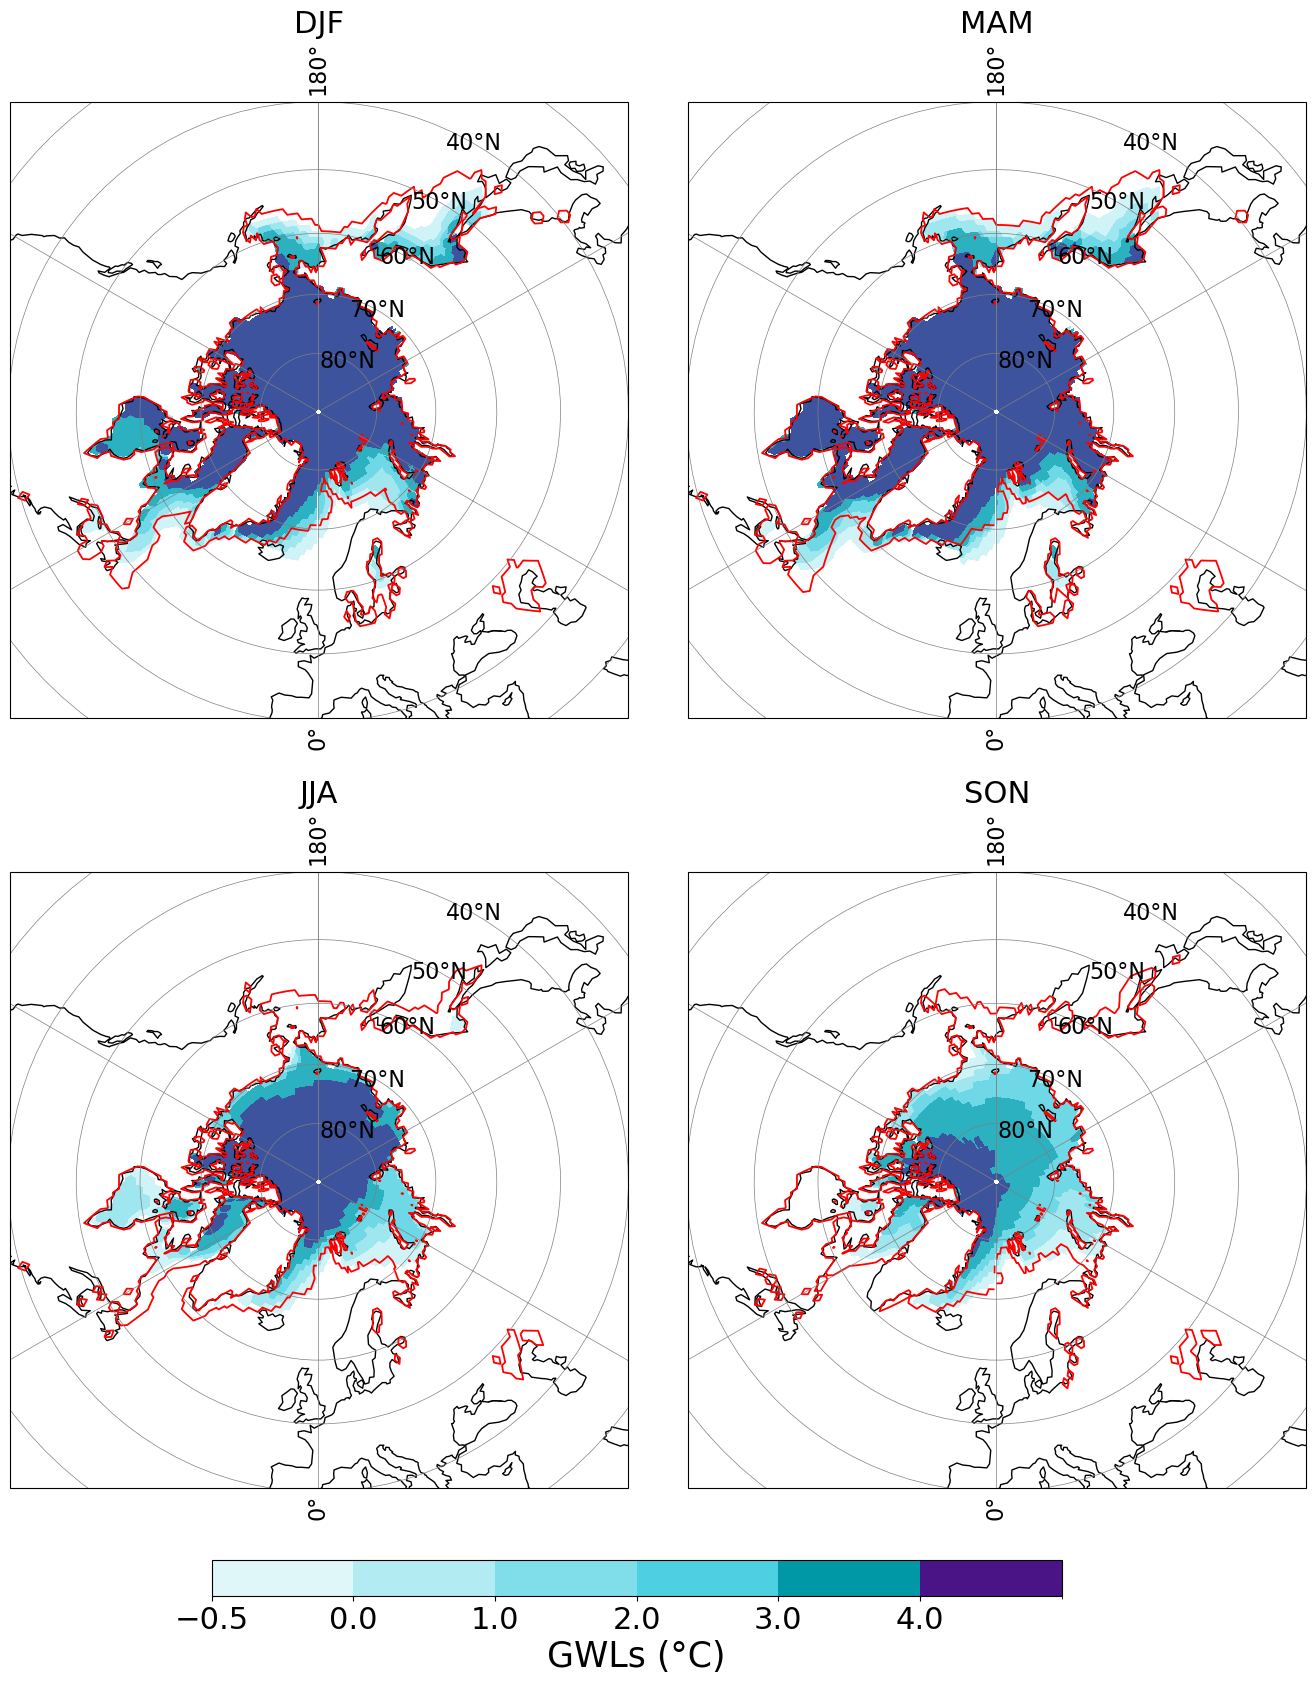

In [34]:
# Plot seasonal sea ice cover maps at different warming levels with consistent colors and colorbar

# Colors
colors = {
    "0°C-ref": "#d7301f",           # rouge pour le scénario de référence
    "-0.5°C": "#e0f7fa",            # bleu très clair (glace fraîche)
    "0°C": "#b2ebf2",               # turquoise pâle
    "1°C": "#80deea",               # turquoise moyen
    "2°C": "#4dd0e1",               # bleu-vert plus profond
    "3°C": "#0097a7",               # bleu pétrole
    "4°C": "#4a1486"                # violet très foncé (retrait maximal)
}

# Dictionary of data by season
season_data = {
    "DJF": {
        "datas": {
            "snow_-0.5°C": djf_siconc_gsat05,
            "snow_0°C": djf_siconc_gsat0,
            "snow_1°C": djf_siconc_gsat1,
            "snow_2°C": djf_siconc_gsat2,
            "snow_3°C": djf_siconc_gsat3,
            "snow_4°C": djf_siconc_gsat4,
        },
        "ref": djf_seaice_reference_binary
    },
    "MAM": {
        "datas": {
            "snow_-0.5°C": mam_siconc_gsat05,
            "snow_0°C": mam_siconc_gsat0,
            "snow_1°C": mam_siconc_gsat1,
            "snow_2°C": mam_siconc_gsat2,
            "snow_3°C": mam_siconc_gsat3,
            "snow_4°C": mam_siconc_gsat4,
        },
        "ref": mam_seaice_reference_binary
    },
    "JJA": {
        "datas": {
            "snow_-0.5°C": jja_siconc_gsat05,
            "snow_0°C": jja_siconc_gsat0,
            "snow_1°C": jja_siconc_gsat1,
            "snow_2°C": jja_siconc_gsat2,
            "snow_3°C": jja_siconc_gsat3,
            "snow_4°C": jja_siconc_gsat4,
        },
        "ref": jja_seaice_reference_binary
    },
    "SON": {
        "datas": {
            "snow_-0.5°C": son_siconc_gsat05,
            "snow_0°C": son_siconc_gsat0,
            "snow_1°C": son_siconc_gsat1,
            "snow_2°C": son_siconc_gsat2,
            "snow_3°C": son_siconc_gsat3,
            "snow_4°C": son_siconc_gsat4,
        },
        "ref": son_seaice_reference_binary
    }
}

# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(17, 18), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.flatten()

# Plot for each season
for ax, (season, content) in zip(axes, season_data.items()):
    plot_seaice_on_ax(ax, content["datas"], content["ref"], season, sftlf, colors)

# Legend
legend_elements = [
    Line2D([0], [0], color=clr, lw=2, label=adjust_label(temp))
    for temp, clr in colors.items()
]

# Actual color scale
temps = [-0.5, 0, +1, +2, +3, +4]
color_list = [
    "#e0f7fa",            
    "#b2ebf2",              
    "#80deea",              
    "#4dd0e1",             
    "#0097a7",
    "#4a1486" 
]

# Create the colormap
cmap = mcolors.ListedColormap(color_list)
norm = mcolors.BoundaryNorm(boundaries=temps + [4.5], ncolors=len(color_list))  # +4.5 to extend upper limit

# Create the colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax,
                    orientation='horizontal',
                    ticks=temps)
cbar.set_label("GWLs (°C)", fontsize=25)
cbar.ax.tick_params(labelsize=22)

# Title
plt.subplots_adjust(wspace=0.06, hspace=0.25)

#plt.savefig("figures/seasonal_snow_extension_15%.png")
plt.show()

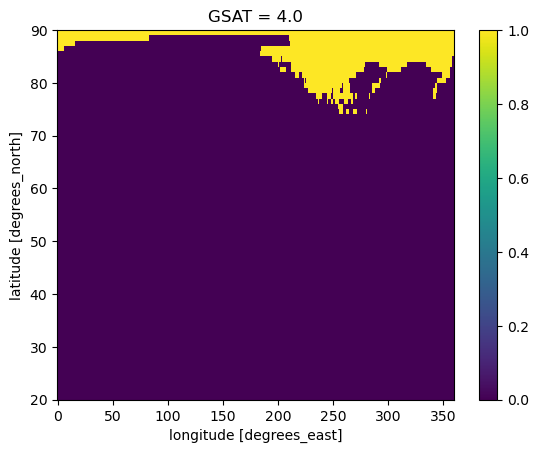

In [35]:
son_siconc_gsat4.plot()

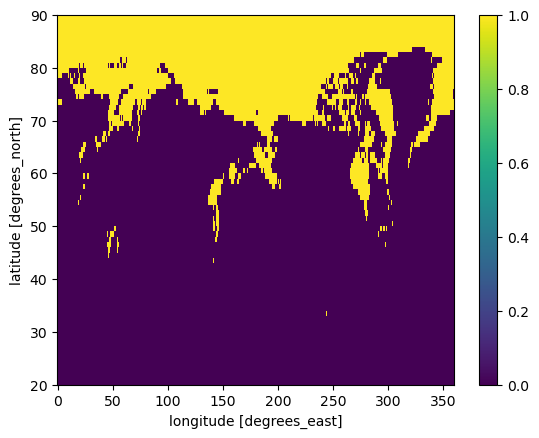

In [36]:
son_seaice_reference_binary.plot()

## Convert to numeric values – Calculate surface areas

In [37]:
# Calculate seasonal snow cover areas in km² by multiplying binary snow presence by cell area and summing over latitude and longitude
area_km2 = area * 1e-6

seaice_cover_km2_winter = (djf_seaice_reference_binary * area_km2).sum(dim=["lat", "lon"], skipna=True) #calcul de la superficie
seaice_cover_km2_spring = (mam_seaice_reference_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_summer = (jja_seaice_reference_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_autumn = (son_seaice_reference_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_winter

<xarray.DataArray ()> Size: 8B
array(17790866.33230208)

In [38]:
# Load the recalculated grid cell area data from the specified NetCDF file
path_areacella = os.path.join("/home/jovyan/private-storage/output_data/areacella_recalcule/", "GFDL-CM4_gridarea_hist_recalcule.nc")
ds_area = xr.open_dataset(path_areacella)

areacella = ds_area["cell_area"]

In [39]:
# Convert cell area to km² and calculate total winter snow-covered area for each warming level
# Reproduce this step for each season

area_km2 = areacella * 1e-6
#winter
seaice_cover_km2_05_winter = (djf_siconc_gsat05 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_0_winter = (djf_siconc_gsat0 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_1_winter = (djf_siconc_gsat1 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_2_winter = (djf_siconc_gsat2 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_3_winter = (djf_siconc_gsat3 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_4_winter = (djf_siconc_gsat4 * area_km2).sum(dim=["lat", "lon"], skipna=True)

In [83]:
djf_siconc_gsat0

<xarray.DataArray (lat: 70, lon: 360)> Size: 202kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
    GSAT     float64 8B 0.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5

In [41]:
#spring
seaice_cover_km2_05_spring = (mam_siconc_gsat05 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_0_spring = (mam_siconc_gsat0 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_1_spring = (mam_siconc_gsat1 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_2_spring = (mam_siconc_gsat2 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_3_spring = (mam_siconc_gsat3 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_4_spring = (mam_siconc_gsat4 * area_km2).sum(dim=["lat", "lon"], skipna=True)

In [42]:
#summer
seaice_cover_km2_05_summer = (jja_siconc_gsat05 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_0_summer = (jja_siconc_gsat0 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_1_summer = (jja_siconc_gsat1 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_2_summer = (jja_siconc_gsat2 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_3_summer = (jja_siconc_gsat3 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_4_summer = (jja_siconc_gsat4 * area_km2).sum(dim=["lat", "lon"], skipna=True)

In [43]:
#autumn
seaice_cover_km2_05_autumn = (son_siconc_gsat05 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_0_autumn = (son_siconc_gsat0 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_1_autumn = (son_siconc_gsat1 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_2_autumn = (son_siconc_gsat2 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_3_autumn = (son_siconc_gsat3 * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_4_autumn = (son_siconc_gsat4 * area_km2).sum(dim=["lat", "lon"], skipna=True)

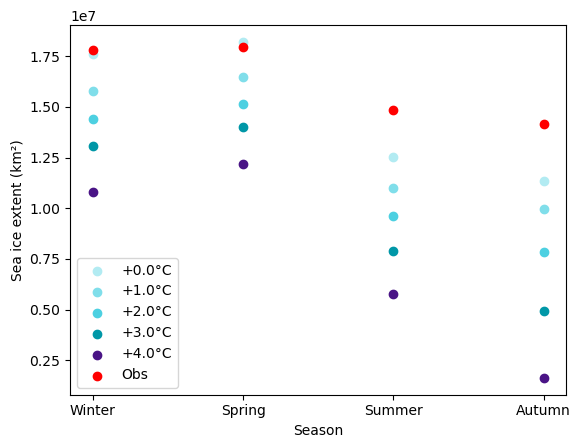

In [44]:
# Plot seasonal snow cover extent (in km²) for different warming levels and observations
seasons = [0, 1, 2, 3]
season_labels = ["Winter", "Spring", "Summer", "Autumn"]

# Plot snow extent for each warming scenario
#plt.scatter(seasons, [seaice_cover_km2_05_winter, seaice_cover_km2_05_spring, seaice_cover_km2_05_summer, seaice_cover_km2_05_autumn], marker="o", label="-0.5°C", color="#e0f7fa")
plt.scatter(seasons, [seaice_cover_km2_0_winter, seaice_cover_km2_0_spring, seaice_cover_km2_0_summer, seaice_cover_km2_0_autumn], marker="o", label="+0.0°C", color="#b2ebf2")
plt.scatter(seasons, [seaice_cover_km2_1_winter, seaice_cover_km2_1_spring, seaice_cover_km2_1_summer, seaice_cover_km2_1_autumn], marker="o", label="+1.0°C", color="#80deea")
plt.scatter(seasons, [seaice_cover_km2_2_winter, seaice_cover_km2_2_spring, seaice_cover_km2_2_summer, seaice_cover_km2_2_autumn], marker="o", label="+2.0°C", color="#4dd0e1")
plt.scatter(seasons, [seaice_cover_km2_3_winter, seaice_cover_km2_3_spring, seaice_cover_km2_3_summer, seaice_cover_km2_3_autumn], marker="o", label="+3.0°C", color="#0097a7")
plt.scatter(seasons, [seaice_cover_km2_4_winter, seaice_cover_km2_4_spring, seaice_cover_km2_4_summer, seaice_cover_km2_4_autumn], marker="o", label="+4.0°C", color="#4a1486")
plt.scatter(seasons, [seaice_cover_km2_winter, seaice_cover_km2_spring, seaice_cover_km2_summer, seaice_cover_km2_autumn], marker="o", label="Obs", color="red")

plt.xticks(seasons, season_labels)
plt.xlabel("Season")
plt.ylabel("Sea ice extent (km²)")
plt.legend()
#plt.savefig("figures/seasonal_snow_extent_km2.png")
plt.show()

Seasonal values of the sea ice cover extent (km2) for each GWL. Each blue color represents a different warming and the red corresponds to the observations.

This figure confirms the initial observations made from the spatial maps. Between -0.5°C and +4°C of warming, the decrease in sea ice cover appears to follow a relatively linear trend.

## Sea ice extent change compared to the reference period

In [45]:
change_winter_0 = ((seaice_cover_km2_winter - seaice_cover_km2_0_winter) / seaice_cover_km2_winter) * 100
change_winter_1 = ((seaice_cover_km2_winter - seaice_cover_km2_1_winter) / seaice_cover_km2_winter) * 100
change_winter_2 = ((seaice_cover_km2_winter - seaice_cover_km2_2_winter) / seaice_cover_km2_winter) * 100
change_winter_3 = ((seaice_cover_km2_winter - seaice_cover_km2_3_winter) / seaice_cover_km2_winter) * 100
change_winter_4 = ((seaice_cover_km2_winter - seaice_cover_km2_4_winter) / seaice_cover_km2_winter) * 100

In [46]:
data_winter = {
    'GWL': [0, 1, 2, 3, 4],  # Global Warming Levels
    'sea_ice_change': [
        - change_winter_0.values,
        - change_winter_1.values,
        - change_winter_2.values,
        - change_winter_3.values,
        - change_winter_4.values
    ]
}

winter_seaice_change = pd.DataFrame(data_winter)

print(winter_seaice_change)

   GWL  sea_ice_change
0    0       -1.002723
1    1      -11.350458
2    2      -18.955416
3    3      -26.413595
4    4      -39.226573


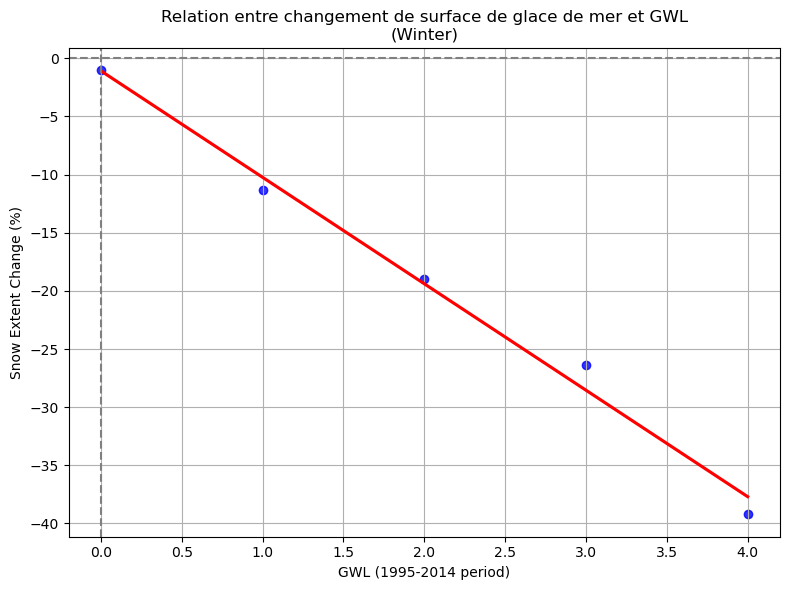

In [47]:
plt.figure(figsize=(8, 6))
sns.regplot(data=winter_seaice_change, x="GWL", y="sea_ice_change", ci=None, color="blue", line_kws={"color": "red"})

plt.axhline(0, color='gray', linestyle='--')  # ligne horizontale à y = 0
plt.axvline(0, color='gray', linestyle='--')  # ligne verticale à x = 0

plt.xlabel("GWL (1995-2014 period)")
plt.ylabel("Snow Extent Change (%)")
plt.title("Relation entre changement de surface de glace de mer et GWL\n(Winter)")

plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
change_spring_0 = ((seaice_cover_km2_spring - seaice_cover_km2_0_spring) / seaice_cover_km2_spring) * 100
change_spring_1 = ((seaice_cover_km2_spring - seaice_cover_km2_1_spring) / seaice_cover_km2_spring) * 100
change_spring_2 = ((seaice_cover_km2_spring - seaice_cover_km2_2_spring) / seaice_cover_km2_spring) * 100
change_spring_3 = ((seaice_cover_km2_spring - seaice_cover_km2_3_spring) / seaice_cover_km2_spring) * 100
change_spring_4 = ((seaice_cover_km2_spring - seaice_cover_km2_4_spring) / seaice_cover_km2_spring) * 100

In [49]:
data_spring = {
    'GWL': [0, 1, 2, 3, 4],  # Global Warming Levels
    'sea_ice_change': [
        - change_spring_0.values,
        - change_spring_1.values,
        - change_spring_2.values,
        - change_spring_3.values,
        - change_spring_4.values
    ]
}

spring_seaice_change = pd.DataFrame(data_spring)

print(spring_seaice_change)

   GWL  sea_ice_change
0    0        1.511690
1    1       -8.189870
2    2      -15.694058
3    3      -21.763838
4    4      -31.947453


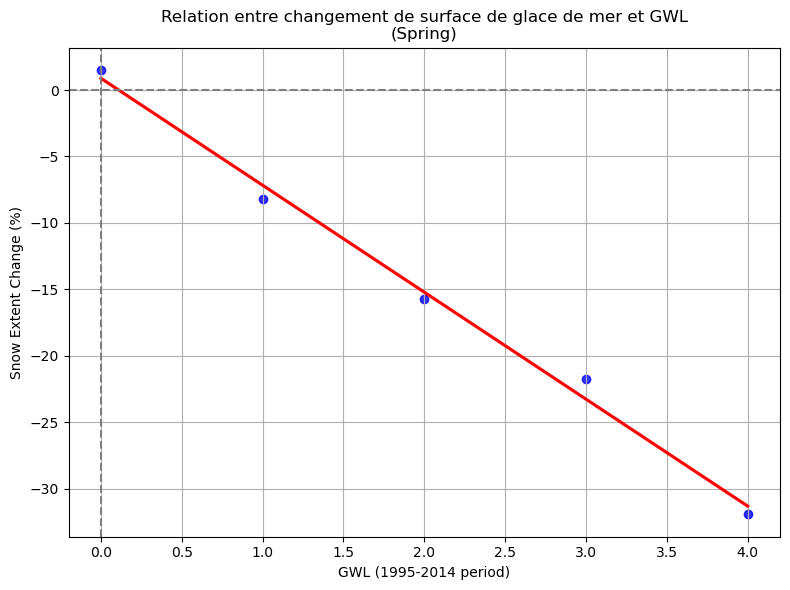

In [50]:
plt.figure(figsize=(8, 6))
sns.regplot(data=spring_seaice_change, x="GWL", y="sea_ice_change", ci=None, color="blue", line_kws={"color": "red"})

plt.axhline(0, color='gray', linestyle='--')  # ligne horizontale à y = 0
plt.axvline(0, color='gray', linestyle='--')  # ligne verticale à x = 0

plt.xlabel("GWL (1995-2014 period)")
plt.ylabel("Snow Extent Change (%)")
plt.title("Relation entre changement de surface de glace de mer et GWL\n(Spring)")

plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
change_summer_0 = ((seaice_cover_km2_summer - seaice_cover_km2_0_summer) / seaice_cover_km2_summer) * 100
change_summer_1 = ((seaice_cover_km2_summer - seaice_cover_km2_1_summer) / seaice_cover_km2_summer) * 100
change_summer_2 = ((seaice_cover_km2_summer - seaice_cover_km2_2_summer) / seaice_cover_km2_summer) * 100
change_summer_3 = ((seaice_cover_km2_summer - seaice_cover_km2_3_summer) / seaice_cover_km2_summer) * 100
change_summer_4 = ((seaice_cover_km2_summer - seaice_cover_km2_4_summer) / seaice_cover_km2_summer) * 100

In [52]:
data_summer = {
    'GWL': [0, 1, 2, 3, 4],  # Global Warming Levels
    'sea_ice_change': [
        - change_summer_0.values,
        - change_summer_1.values,
        - change_summer_2.values,
        - change_summer_3.values,
        - change_summer_4.values
    ]
}

summer_seaice_change = pd.DataFrame(data_summer)

print(summer_seaice_change)

   GWL  sea_ice_change
0    0      -15.594204
1    1      -26.068963
2    2      -35.384572
3    3      -47.002630
4    4      -61.218433


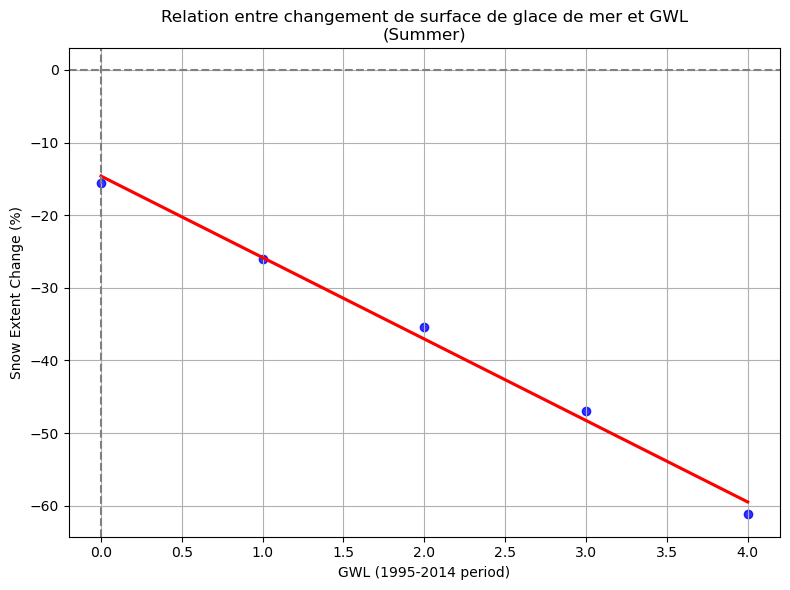

In [53]:
plt.figure(figsize=(8, 6))
sns.regplot(data=summer_seaice_change, x="GWL", y="sea_ice_change", ci=None, color="blue", line_kws={"color": "red"})

plt.axhline(0, color='gray', linestyle='--')  # ligne horizontale à y = 0
plt.axvline(0, color='gray', linestyle='--')  # ligne verticale à x = 0

plt.xlabel("GWL (1995-2014 period)")
plt.ylabel("Snow Extent Change (%)")
plt.title("Relation entre changement de surface de glace de mer et GWL\n(Summer)")

plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
change_autumn_0 = ((seaice_cover_km2_autumn - seaice_cover_km2_0_autumn) / seaice_cover_km2_autumn) * 100
change_autumn_1 = ((seaice_cover_km2_autumn - seaice_cover_km2_1_autumn) / seaice_cover_km2_autumn) * 100
change_autumn_2 = ((seaice_cover_km2_autumn - seaice_cover_km2_2_autumn) / seaice_cover_km2_autumn) * 100
change_autumn_3 = ((seaice_cover_km2_autumn - seaice_cover_km2_3_autumn) / seaice_cover_km2_autumn) * 100
change_autumn_4 = ((seaice_cover_km2_autumn - seaice_cover_km2_4_autumn) / seaice_cover_km2_autumn) * 100

In [55]:
data_autumn = {
    'GWL': [0, 1, 2, 3, 4],  # Global Warming Levels
    'sea_ice_change': [
        - change_autumn_0.values,
        - change_autumn_1.values,
        - change_autumn_2.values,
        - change_autumn_3.values,
        - change_autumn_4.values
    ]
}

autumn_seaice_change = pd.DataFrame(data_autumn)

print(autumn_seaice_change)

   GWL  sea_ice_change
0    0      -19.917761
1    1      -29.683422
2    2      -44.490896
3    3      -65.292985
4    4      -88.487130


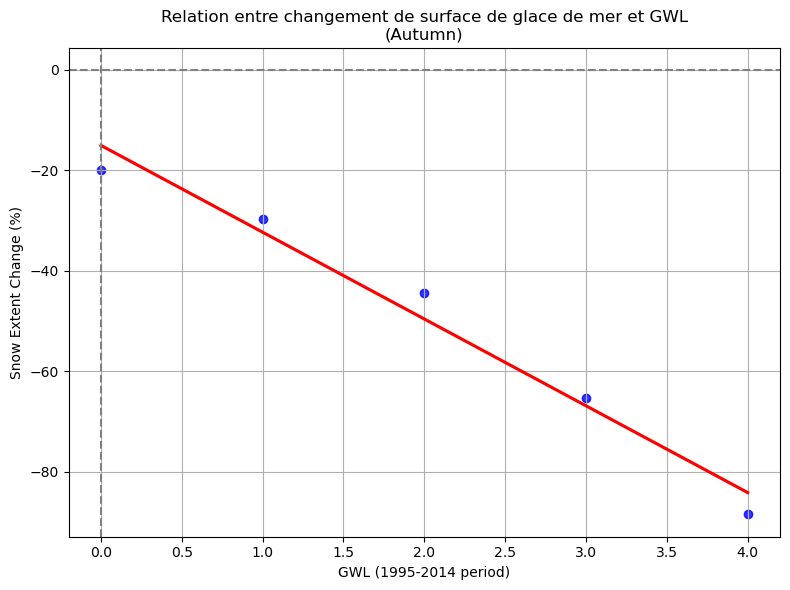

In [56]:
plt.figure(figsize=(8, 6))
sns.regplot(data=autumn_seaice_change, x="GWL", y="sea_ice_change", ci=None, color="blue", line_kws={"color": "red"})

plt.axhline(0, color='gray', linestyle='--')  # ligne horizontale à y = 0
plt.axvline(0, color='gray', linestyle='--')  # ligne verticale à x = 0

plt.xlabel("GWL (1995-2014 period)")
plt.ylabel("Snow Extent Change (%)")
plt.title("Relation entre changement de surface de glace de mer et GWL\n(Autumn)")

plt.grid(True)
plt.tight_layout()
plt.show()

### All the seasons on the same figure

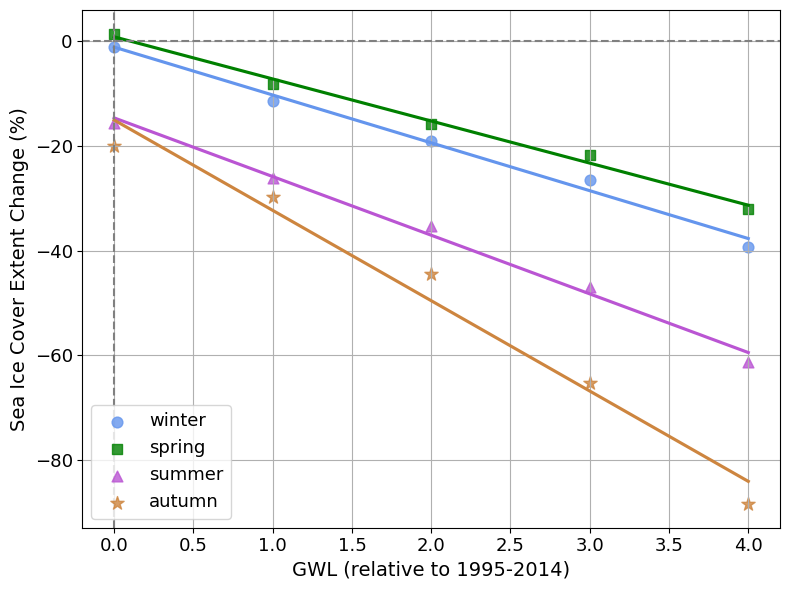

In [57]:
plt.figure(figsize=(8, 6))

#colors
colors = {
    "winter": "cornflowerblue",  
    "spring": "green", 
    "summer": "mediumorchid", 
    "autumn": "peru", 
}

sns.regplot(
    data=winter_seaice_change, x="GWL", y="sea_ice_change", ci=None,
    label="winter", marker='o', scatter_kws={"s": 60}, color=colors["winter"]
)

sns.regplot(
    data=spring_seaice_change, x="GWL", y="sea_ice_change", ci=None,
    label="spring", marker='s', scatter_kws={"s": 60}, color=colors["spring"]
)

sns.regplot(
    data=summer_seaice_change, x="GWL", y="sea_ice_change", ci=None,
    label="summer", marker='^', scatter_kws={"s": 60}, color=colors["summer"]
)

sns.regplot(
    data=autumn_seaice_change, x="GWL", y="sea_ice_change", ci=None,
    label="autumn", marker='*', scatter_kws={"s": 100}, color=colors["autumn"]
)

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

plt.xlabel("GWL (relative to 1995-2014)", fontsize=14)
plt.ylabel("Sea Ice Cover Extent Change (%)", fontsize=14)
plt.legend(loc="lower left", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.tight_layout()
#plt.savefig("figures/snow_cover_extent_change_15%_bis.png")
plt.show()

# Multi-model mean - Monthly maps

### Reference

In [58]:
july_siconc_ref = seaice_cover[6]
august_siconc_ref = seaice_cover[7]
september_siconc_ref = seaice_cover[8]
october_siconc_ref = seaice_cover[9]

In [59]:
july_siconc_ref_binary = (july_siconc_ref > 0.15).astype(int)
august_siconc_ref_binary = (august_siconc_ref > 0.15).astype(int)
september_siconc_ref_binary = (september_siconc_ref > 0.15).astype(int)
october_siconc_ref_binary = (october_siconc_ref > 0.15).astype(int)

In [60]:
july_siconc_ref

<xarray.DataArray (lat: 180, lon: 360)> Size: 518kB
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ...,
       [98.638489, 98.629425, 98.620331, ..., 98.666405, 98.656883, 98.647636],
       [98.664619, 98.658096, 98.651718, ..., 98.685181, 98.678322, 98.671402],
       [98.693077, 98.688988, 98.68486 , ..., 98.70491 , 98.700958, 98.697037]])
Coordinates:
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    month    int64 8B 7

### Models

In [61]:
july_siconc_gsat0_pondere = siconc_gsat0_pondere[6]
july_siconc_gsat0_pondere

<xarray.DataArray (lat: 70, lon: 360)> Size: 202kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.90687671, 0.90590105, 0.90605629, ..., 0.90755741, 0.90729857,
        0.9070165 ],
       [0.90570184, 0.9053832 , 0.90535535, ..., 0.90660796, 0.90657539,
        0.90577222],
       [0.90258023, 0.90254723, 0.90244159, ..., 0.90268482, 0.90257685,
        0.90257832]])
Coordinates:
    month    float64 8B 7.0
    GSAT     float64 8B 0.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5

In [62]:
august_siconc_gsat0_pondere = siconc_gsat0_pondere[7]
august_siconc_gsat0_pondere

<xarray.DataArray (lat: 70, lon: 360)> Size: 202kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.87386825, 0.87275336, 0.87340249, ..., 0.87464286, 0.87433235,
        0.87387965],
       [0.87206574, 0.87170694, 0.87163855, ..., 0.87309194, 0.87307197,
        0.87216497],
       [0.86766129, 0.8673923 , 0.86629449, ..., 0.86813979, 0.86765892,
        0.867662  ]])
Coordinates:
    month    float64 8B 8.0
    GSAT     float64 8B 0.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5

In [63]:
september_siconc_gsat0_pondere = siconc_gsat0_pondere[8]
september_siconc_gsat0_pondere

<xarray.DataArray (lat: 70, lon: 360)> Size: 202kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.92526012, 0.92504592, 0.92550404, ..., 0.92587506, 0.92575172,
        0.92533503],
       [0.92659417, 0.92654882, 0.92654518, ..., 0.9266826 , 0.92666195,
        0.9266462 ],
       [0.92496714, 0.92504173, 0.92511093, ..., 0.92513753, 0.92496869,
        0.92496862]])
Coordinates:
    month    float64 8B 9.0
    GSAT     float64 8B 0.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5

In [64]:
october_siconc_gsat0_pondere = siconc_gsat0_pondere[9]
october_siconc_gsat0_pondere

<xarray.DataArray (lat: 70, lon: 360)> Size: 202kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.97836   , 0.97833594, 0.97834503, ..., 0.97840566, 0.9783597 ,
        0.97833366],
       [0.97905678, 0.97903638, 0.97903175, ..., 0.9790809 , 0.97907037,
        0.97906006],
       [0.9795615 , 0.97953019, 0.9796356 , ..., 0.97958372, 0.97956275,
        0.97956272]])
Coordinates:
    month    float64 8B 10.0
    GSAT     float64 8B 0.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5

In [65]:
july_siconc_gsat1_pondere = siconc_gsat1_pondere[6]
august_siconc_gsat1_pondere = siconc_gsat1_pondere[7]
september_siconc_gsat1_pondere = siconc_gsat1_pondere[8]
october_siconc_gsat1_pondere = siconc_gsat1_pondere[9]

In [66]:
july_siconc_gsat2_pondere = siconc_gsat2_pondere[6]
august_siconc_gsat2_pondere = siconc_gsat2_pondere[7]
september_siconc_gsat2_pondere = siconc_gsat2_pondere[8]
october_siconc_gsat2_pondere = siconc_gsat2_pondere[9]

In [67]:
july_siconc_gsat3_pondere = siconc_gsat3_pondere[6]
august_siconc_gsat3_pondere = siconc_gsat3_pondere[7]
september_siconc_gsat3_pondere = siconc_gsat3_pondere[8]
october_siconc_gsat3_pondere = siconc_gsat3_pondere[9]

In [68]:
july_siconc_gsat4_pondere = siconc_gsat4_pondere[6]
august_siconc_gsat4_pondere = siconc_gsat4_pondere[7]
september_siconc_gsat4_pondere = siconc_gsat4_pondere[8]
october_siconc_gsat4_pondere = siconc_gsat4_pondere[9]

In [69]:
july_siconc_gsat0_binary = (july_siconc_gsat0_pondere > 0.15).astype(int)
july_siconc_gsat1_binary = (july_siconc_gsat1_pondere > 0.15).astype(int)
july_siconc_gsat2_binary = (july_siconc_gsat2_pondere > 0.15).astype(int)
july_siconc_gsat3_binary = (july_siconc_gsat3_pondere > 0.15).astype(int)
july_siconc_gsat4_binary = (july_siconc_gsat4_pondere > 0.15).astype(int)

In [70]:
august_siconc_gsat0_binary = (august_siconc_gsat0_pondere > 0.15).astype(int)
august_siconc_gsat1_binary = (august_siconc_gsat1_pondere > 0.15).astype(int)
august_siconc_gsat2_binary = (august_siconc_gsat2_pondere > 0.15).astype(int)
august_siconc_gsat3_binary = (august_siconc_gsat3_pondere > 0.15).astype(int)
august_siconc_gsat4_binary = (august_siconc_gsat4_pondere > 0.15).astype(int)

In [71]:
september_siconc_gsat0_binary = (september_siconc_gsat0_pondere > 0.15).astype(int)
september_siconc_gsat1_binary = (september_siconc_gsat1_pondere > 0.15).astype(int)
september_siconc_gsat2_binary = (september_siconc_gsat2_pondere > 0.15).astype(int)
september_siconc_gsat3_binary = (september_siconc_gsat3_pondere > 0.15).astype(int)
september_siconc_gsat4_binary = (september_siconc_gsat4_pondere > 0.15).astype(int)

In [72]:
october_siconc_gsat0_binary = (october_siconc_gsat0_pondere > 0.15).astype(int)
october_siconc_gsat1_binary = (october_siconc_gsat1_pondere > 0.15).astype(int)
october_siconc_gsat2_binary = (october_siconc_gsat2_pondere > 0.15).astype(int)
october_siconc_gsat3_binary = (october_siconc_gsat3_pondere > 0.15).astype(int)
october_siconc_gsat4_binary = (october_siconc_gsat4_pondere > 0.15).astype(int)

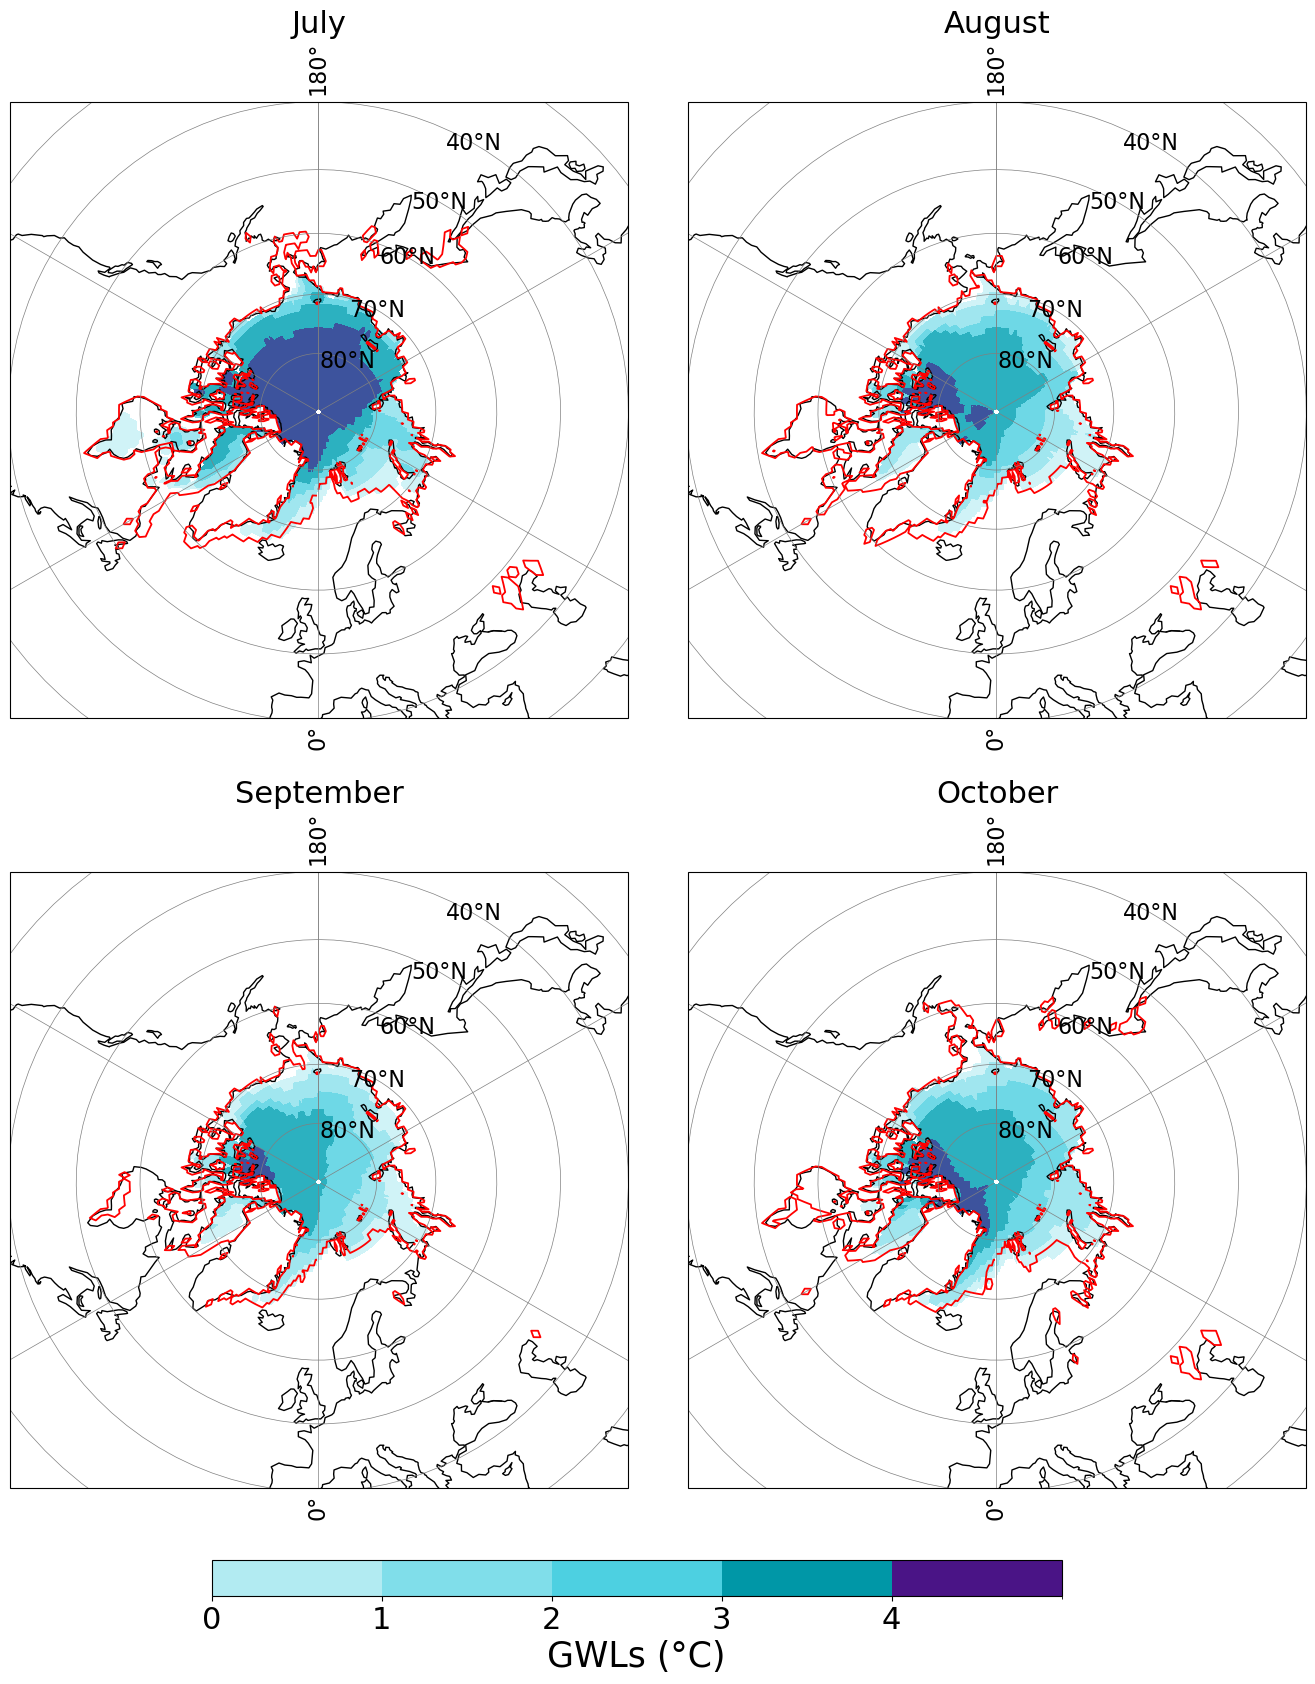

In [73]:
# Plot seasonal sea ice cover maps at different warming levels with consistent colors and colorbar

# Colors
colors = {
    "0°C-ref": "#d7301f",           # rouge pour le scénario de référence
    "-0.5°C": "#e0f7fa",            # bleu très clair (glace fraîche)
    "0°C": "#b2ebf2",               # turquoise pâle
    "1°C": "#80deea",               # turquoise moyen
    "2°C": "#4dd0e1",               # bleu-vert plus profond
    "3°C": "#0097a7",               # bleu pétrole
    "4°C": "#4a1486"                # violet très foncé (retrait maximal)
}

# Dictionary of data by season
season_data = {
    "July": {
        "datas": {
            "seaice_0°C": july_siconc_gsat0_binary ,
            "seaice_1°C": july_siconc_gsat1_binary ,
            "seaice_2°C": july_siconc_gsat2_binary ,
            "seaice_3°C": july_siconc_gsat3_binary ,
            "seaice_4°C": july_siconc_gsat4_binary ,
        },
        "ref": july_siconc_ref_binary
    },
    "August": {
        "datas": {
            "seaice_0°C": august_siconc_gsat0_binary,
            "seaice_1°C": august_siconc_gsat1_binary,
            "seaice_2°C": august_siconc_gsat2_binary,
            "seaice_3°C": august_siconc_gsat3_binary,
            "seaice_4°C": august_siconc_gsat4_binary,
        },
        "ref": august_siconc_ref_binary
    },
    "September": {
        "datas": {
            "seaice_0°C": september_siconc_gsat0_binary,
            "seaice_1°C": september_siconc_gsat1_binary,
            "seaice_2°C": september_siconc_gsat2_binary,
            "seaice_3°C": september_siconc_gsat3_binary,
            "seaice_4°C": september_siconc_gsat4_binary,
        },
        "ref": september_siconc_ref_binary
    },
    "October": {
        "datas": {
            "seaice_0°C": october_siconc_gsat0_binary,
            "seaice_1°C": october_siconc_gsat1_binary,
            "seaice_2°C": october_siconc_gsat2_binary,
            "seaice_3°C": october_siconc_gsat3_binary,
            "seaice_4°C": october_siconc_gsat4_binary,
        },
        "ref": october_siconc_ref_binary
    }
}

# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(17, 18), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.flatten()

# Plot for each season
for ax, (season, content) in zip(axes, season_data.items()):
    plot_seaice_on_ax(ax, content["datas"], content["ref"], season, sftlf, colors)

# Legend
legend_elements = [
    Line2D([0], [0], color=clr, lw=2, label=adjust_label(temp))
    for temp, clr in colors.items()
]

# Actual color scale
temps = [0, +1, +2, +3, +4]
color_list = [            
    "#b2ebf2",              
    "#80deea",              
    "#4dd0e1",             
    "#0097a7",
    "#4a1486" 
]

# Create the colormap
cmap = mcolors.ListedColormap(color_list)
norm = mcolors.BoundaryNorm(boundaries=temps + [4.5], ncolors=len(color_list))  # +4.5 to extend upper limit

# Create the colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax,
                    orientation='horizontal',
                    ticks=temps)
cbar.set_label("GWLs (°C)", fontsize=25)
cbar.ax.tick_params(labelsize=22)

# Title
plt.subplots_adjust(wspace=0.06, hspace=0.25)

#plt.savefig("figures/seasonal_snow_extension_15%.png")
plt.show()

## Convert to numerical values

In [74]:
# path and file of the area
path = "/home/jovyan/M2_SeaIce_project/Data/input_data/areacella/gridarea_seaice_ref.nc"
area = xr.open_dataset(path)

In [75]:
# Calculate seasonal sea ice cover areas in km² by multiplying binary sea ice presence by cell area and summing over latitude and longitude
area_km2 = area["cell_area"] * 1e-6

In [86]:
july_siconc_ref_binary = july_siconc_ref_binary.sel(lat=july_siconc_ref_binary.lat >= 20)
august_siconc_ref_binary = august_siconc_ref_binary.sel(lat=august_siconc_ref_binary.lat >= 20)
september_siconc_ref_binary = september_siconc_ref_binary.sel(lat=september_siconc_ref_binary.lat >= 20)
october_siconc_ref_binary = october_siconc_ref_binary.sel(lat=october_siconc_ref_binary.lat >= 20)

In [87]:
seaice_cover_km2_july = (july_siconc_ref_binary * area_km2).sum(dim=["lat", "lon"], skipna=True) #calcul de la superficie
seaice_cover_km2_august = (august_siconc_ref_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_september = (september_siconc_ref_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_october = (october_siconc_ref_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)

In [89]:
# Load the recalculated grid cell area data from the specified NetCDF file
path_areacella = os.path.join("/home/jovyan/private-storage/output_data/areacella_recalcule/", "GFDL-CM4_gridarea_hist_recalcule.nc")
ds_area = xr.open_dataset(path_areacella)

areacella = ds_area["cell_area"]

In [90]:
# Convert cell area to km² and calculate total winter sea ice-covered area for each warming level
# Reproduce this step for each month of interest

area_km2 = areacella * 1e-6
#july
seaice_cover_km2_0_july = (july_siconc_gsat0_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_1_july = (july_siconc_gsat1_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_2_july = (july_siconc_gsat2_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_3_july = (july_siconc_gsat3_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_4_july = (july_siconc_gsat4_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)

In [91]:
# august
seaice_cover_km2_0_august = (august_siconc_gsat0_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_1_august = (august_siconc_gsat1_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_2_august = (august_siconc_gsat2_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_3_august = (august_siconc_gsat3_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_4_august = (august_siconc_gsat4_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)

In [92]:
# september
seaice_cover_km2_0_september = (september_siconc_gsat0_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_1_september = (september_siconc_gsat1_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_2_september = (september_siconc_gsat2_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_3_september = (september_siconc_gsat3_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_4_september = (september_siconc_gsat4_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)

In [93]:
# october
seaice_cover_km2_0_october = (october_siconc_gsat0_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_1_october = (october_siconc_gsat1_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_2_october = (october_siconc_gsat2_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_3_october = (october_siconc_gsat3_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)
seaice_cover_km2_4_october = (october_siconc_gsat4_binary * area_km2).sum(dim=["lat", "lon"], skipna=True)

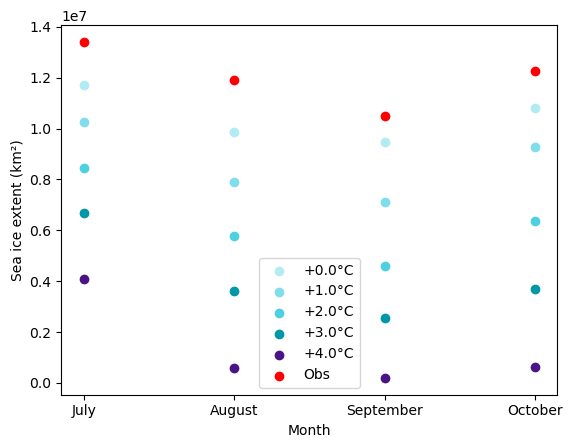

In [94]:
# Plot seasonal snow cover extent (in km²) for different warming levels and observations
months = [0, 1, 2, 3]
month_labels = ["July", "August", "September", "October"]

# Plot snow extent for each warming scenario
plt.scatter(months, [seaice_cover_km2_0_july, seaice_cover_km2_0_august, seaice_cover_km2_0_september, seaice_cover_km2_0_october], marker="o", label="+0.0°C", color="#b2ebf2")
plt.scatter(months, [seaice_cover_km2_1_july, seaice_cover_km2_1_august, seaice_cover_km2_1_september, seaice_cover_km2_1_october], marker="o", label="+1.0°C", color="#80deea")
plt.scatter(months, [seaice_cover_km2_2_july, seaice_cover_km2_2_august, seaice_cover_km2_2_september, seaice_cover_km2_2_october], marker="o", label="+2.0°C", color="#4dd0e1")
plt.scatter(months, [seaice_cover_km2_3_july, seaice_cover_km2_3_august, seaice_cover_km2_3_september, seaice_cover_km2_3_october], marker="o", label="+3.0°C", color="#0097a7")
plt.scatter(months, [seaice_cover_km2_4_july, seaice_cover_km2_4_august, seaice_cover_km2_4_september, seaice_cover_km2_4_october], marker="o", label="+4.0°C", color="#4a1486")
plt.scatter(months, [seaice_cover_km2_july, seaice_cover_km2_august, seaice_cover_km2_september, seaice_cover_km2_october], marker="o", label="Obs", color="red")

plt.xticks(months, month_labels)
plt.xlabel("Month")
plt.ylabel("Sea ice extent (km²)")
plt.legend()
#plt.savefig("figures/seasonal_snow_extent_km2.png")
plt.show()

## Sea ice extent change compared to the reference period

In [95]:
change_july_0 = ((seaice_cover_km2_july - seaice_cover_km2_0_july) / seaice_cover_km2_july) * 100
change_july_1 = ((seaice_cover_km2_july - seaice_cover_km2_1_july) / seaice_cover_km2_july) * 100
change_july_2 = ((seaice_cover_km2_july - seaice_cover_km2_2_july) / seaice_cover_km2_july) * 100
change_july_3 = ((seaice_cover_km2_july - seaice_cover_km2_3_july) / seaice_cover_km2_july) * 100
change_july_4 = ((seaice_cover_km2_july - seaice_cover_km2_4_july) / seaice_cover_km2_july) * 100

In [96]:
data_july = {
    'GWL': [0, 1, 2, 3, 4],  # Global Warming Levels
    'sea_ice_change': [
        - change_july_0.values,
        - change_july_1.values,
        - change_july_2.values,
        - change_july_3.values,
        - change_july_4.values
    ]
}

july_seaice_change = pd.DataFrame(data_july)

print(july_seaice_change)

   GWL  sea_ice_change
0    0      -12.554390
1    1      -23.544332
2    2      -37.013340
3    3      -50.114172
4    4      -69.542305


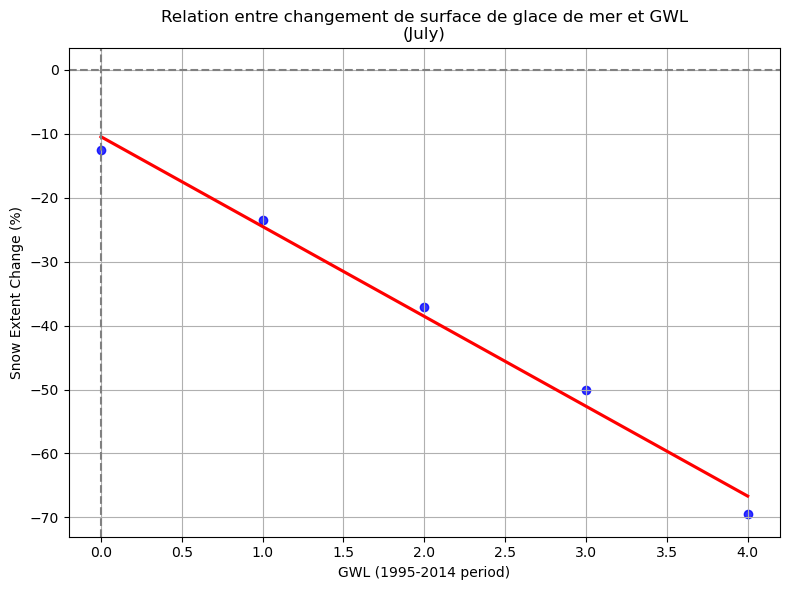

In [97]:
plt.figure(figsize=(8, 6))
sns.regplot(data=july_seaice_change, x="GWL", y="sea_ice_change", ci=None, color="blue", line_kws={"color": "red"})

plt.axhline(0, color='gray', linestyle='--')  # ligne horizontale à y = 0
plt.axvline(0, color='gray', linestyle='--')  # ligne verticale à x = 0

plt.xlabel("GWL (1995-2014 period)")
plt.ylabel("Snow Extent Change (%)")
plt.title("Relation entre changement de surface de glace de mer et GWL\n(July)")

plt.grid(True)
plt.tight_layout()
plt.show()

In [98]:
change_august_0 = ((seaice_cover_km2_august - seaice_cover_km2_0_august) / seaice_cover_km2_august) * 100
change_august_1 = ((seaice_cover_km2_august - seaice_cover_km2_1_august) / seaice_cover_km2_august) * 100
change_august_2 = ((seaice_cover_km2_august - seaice_cover_km2_2_august) / seaice_cover_km2_august) * 100
change_august_3 = ((seaice_cover_km2_august - seaice_cover_km2_3_august) / seaice_cover_km2_august) * 100
change_august_4 = ((seaice_cover_km2_august - seaice_cover_km2_4_august) / seaice_cover_km2_august) * 100

In [99]:
data_august = {
    'GWL': [0, 1, 2, 3, 4],  # Global Warming Levels
    'sea_ice_change': [
        - change_august_0.values,
        - change_august_1.values,
        - change_august_2.values,
        - change_august_3.values,
        - change_august_4.values
    ]
}

august_seaice_change = pd.DataFrame(data_august)

print(august_seaice_change)

   GWL  sea_ice_change
0    0      -17.160021
1    1      -33.859637
2    2      -51.631586
3    3      -69.543285
4    4      -95.240779


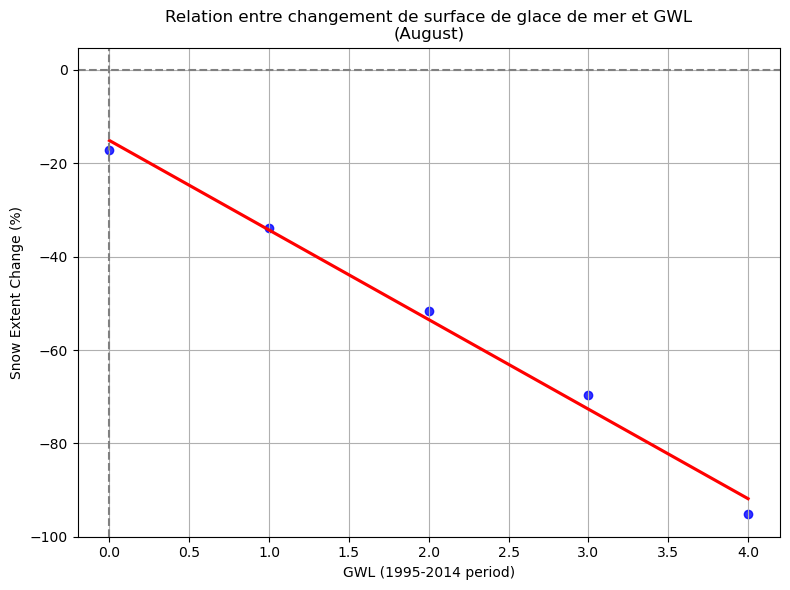

In [100]:
plt.figure(figsize=(8, 6))
sns.regplot(data=august_seaice_change, x="GWL", y="sea_ice_change", ci=None, color="blue", line_kws={"color": "red"})

plt.axhline(0, color='gray', linestyle='--')  # ligne horizontale à y = 0
plt.axvline(0, color='gray', linestyle='--')  # ligne verticale à x = 0

plt.xlabel("GWL (1995-2014 period)")
plt.ylabel("Snow Extent Change (%)")
plt.title("Relation entre changement de surface de glace de mer et GWL\n(August)")

plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
change_september_0 = ((seaice_cover_km2_september - seaice_cover_km2_0_september) / seaice_cover_km2_september) * 100
change_september_1 = ((seaice_cover_km2_september - seaice_cover_km2_1_september) / seaice_cover_km2_september) * 100
change_september_2 = ((seaice_cover_km2_september - seaice_cover_km2_2_september) / seaice_cover_km2_september) * 100
change_september_3 = ((seaice_cover_km2_september - seaice_cover_km2_3_september) / seaice_cover_km2_september) * 100
change_september_4 = ((seaice_cover_km2_september - seaice_cover_km2_4_september) / seaice_cover_km2_september) * 100

In [102]:
data_september = {
    'GWL': [0, 1, 2, 3, 4],  # Global Warming Levels
    'sea_ice_change': [
        - change_september_0.values,
        - change_september_1.values,
        - change_september_2.values,
        - change_september_3.values,
        - change_september_4.values
    ]
}

september_seaice_change = pd.DataFrame(data_september)

print(september_seaice_change)

   GWL  sea_ice_change
0    0       -9.636664
1    1      -32.276070
2    2      -56.032226
3    3      -75.834689
4    4      -98.121288


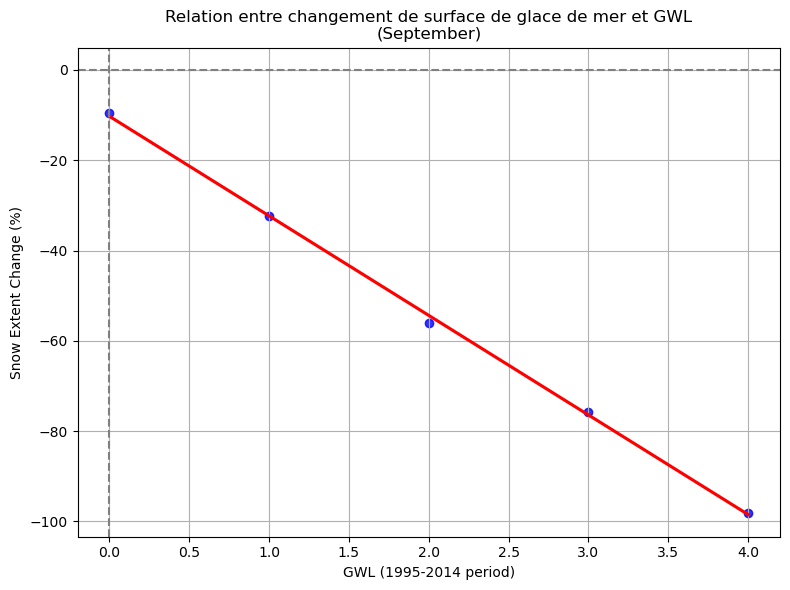

In [103]:
plt.figure(figsize=(8, 6))
sns.regplot(data=september_seaice_change, x="GWL", y="sea_ice_change", ci=None, color="blue", line_kws={"color": "red"})

plt.axhline(0, color='gray', linestyle='--')  # ligne horizontale à y = 0
plt.axvline(0, color='gray', linestyle='--')  # ligne verticale à x = 0

plt.xlabel("GWL (1995-2014 period)")
plt.ylabel("Snow Extent Change (%)")
plt.title("Relation entre changement de surface de glace de mer et GWL\n(September)")

plt.grid(True)
plt.tight_layout()
plt.show()

In [104]:
change_october_0 = ((seaice_cover_km2_october - seaice_cover_km2_0_october) / seaice_cover_km2_october) * 100
change_october_1 = ((seaice_cover_km2_october - seaice_cover_km2_1_october) / seaice_cover_km2_october) * 100
change_october_2 = ((seaice_cover_km2_october - seaice_cover_km2_2_october) / seaice_cover_km2_october) * 100
change_october_3 = ((seaice_cover_km2_october - seaice_cover_km2_3_october) / seaice_cover_km2_october) * 100
change_october_4 = ((seaice_cover_km2_october - seaice_cover_km2_4_october) / seaice_cover_km2_october) * 100

In [105]:
data_october = {
    'GWL': [0, 1, 2, 3, 4],  # Global Warming Levels
    'sea_ice_change': [
        - change_october_0.values,
        - change_october_1.values,
        - change_october_2.values,
        - change_october_3.values,
        - change_october_4.values
    ]
}

october_seaice_change = pd.DataFrame(data_october)

print(october_seaice_change)

   GWL  sea_ice_change
0    0      -11.768919
1    1      -24.215828
2    2      -47.937040
3    3      -69.864744
4    4      -94.897208


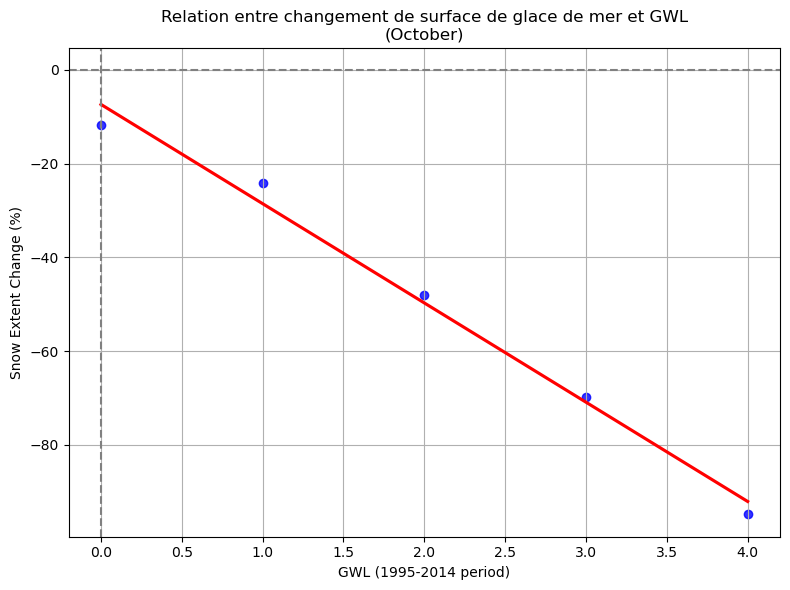

In [106]:
plt.figure(figsize=(8, 6))
sns.regplot(data=october_seaice_change, x="GWL", y="sea_ice_change", ci=None, color="blue", line_kws={"color": "red"})

plt.axhline(0, color='gray', linestyle='--')  # ligne horizontale à y = 0
plt.axvline(0, color='gray', linestyle='--')  # ligne verticale à x = 0

plt.xlabel("GWL (1995-2014 period)")
plt.ylabel("Snow Extent Change (%)")
plt.title("Relation entre changement de surface de glace de mer et GWL\n(October)")

plt.grid(True)
plt.tight_layout()
plt.show()

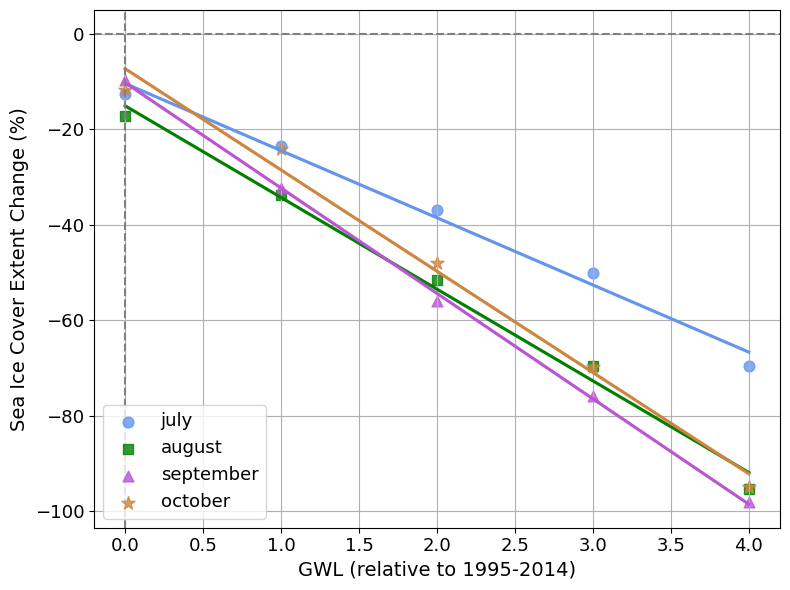

In [107]:
plt.figure(figsize=(8, 6))

#colors
colors = {
    "july": "cornflowerblue",  
    "august": "green", 
    "september": "mediumorchid", 
    "october": "peru", 
}

sns.regplot(
    data=july_seaice_change, x="GWL", y="sea_ice_change", ci=None,
    label="july", marker='o', scatter_kws={"s": 60}, color=colors["july"]
)

sns.regplot(
    data=august_seaice_change, x="GWL", y="sea_ice_change", ci=None,
    label="august", marker='s', scatter_kws={"s": 60}, color=colors["august"]
)

sns.regplot(
    data=september_seaice_change, x="GWL", y="sea_ice_change", ci=None,
    label="september", marker='^', scatter_kws={"s": 60}, color=colors["september"]
)

sns.regplot(
    data=october_seaice_change, x="GWL", y="sea_ice_change", ci=None,
    label="october", marker='*', scatter_kws={"s": 100}, color=colors["october"]
)

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

plt.xlabel("GWL (relative to 1995-2014)", fontsize=14)
plt.ylabel("Sea Ice Cover Extent Change (%)", fontsize=14)
plt.legend(loc="lower left", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.tight_layout()
#plt.savefig("figures/snow_cover_extent_change_15%_bis.png")
plt.show()